## Correlation

### 1. Anomalies and Boundary Points

In [1]:
from orix import io
from process_indexing_data import compute_roi_misorientation_map_from_xmap, extract_roi_quaternions, match_data_by_coords, analyze_quaternion_scores_relationship, analyze_quaternion_variations_relationship, plot_phase_heatmap, normalize_misorientation_by_phase_map, plot_element_vs_pca
import kikuchipy as kp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ast
from visualize_grid import read_data, set_ROI, set_component
from data_processing import get_eds_average, coord_xmap_dict, get_components, add_gaussian_noise_to_kikuchi_patterns
from cNMF import run_cNMF, run_cNMF_mixeds, _plot_cnmf, normalize_sum, detect_anomalies_cnmf, plot_weight_map_cnmf_with_anomalies, plot_weight_map_cnmf, reconstruct_weighted_signals
from PCA import run_PCA, _plot_pca, detect_anomalies_pca, plot_weight_map_pca, plot_explained_variance, reconstruct_pca_signals
from cluster_analysis import gmm_clustering, calculate_cluster_metrics, plot_cnmf_scatter_with_boundary, plot_cluster_distances_ranking, find_best_reference_window, plot_cluster_heatmap, evaluate_clustering_metrics, plot_intra_cluster_variation_map, compute_mahalanobis_to_reference

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\orix\io\plugins\ang.py:285: UserWarning: Number of columns, 20, in the file is not equal to the expected number of columns, [14, 10], for the 
assumed vendor 'tsl'. Will therefore assume the following columns: euler1, euler2, euler3, x, y, unknown1, unknown2, phase_id, unknown3, unknown4, etc.
  warnings.warn(


x dimensions 62 
 y dimensions 41 
 in multiples of 1


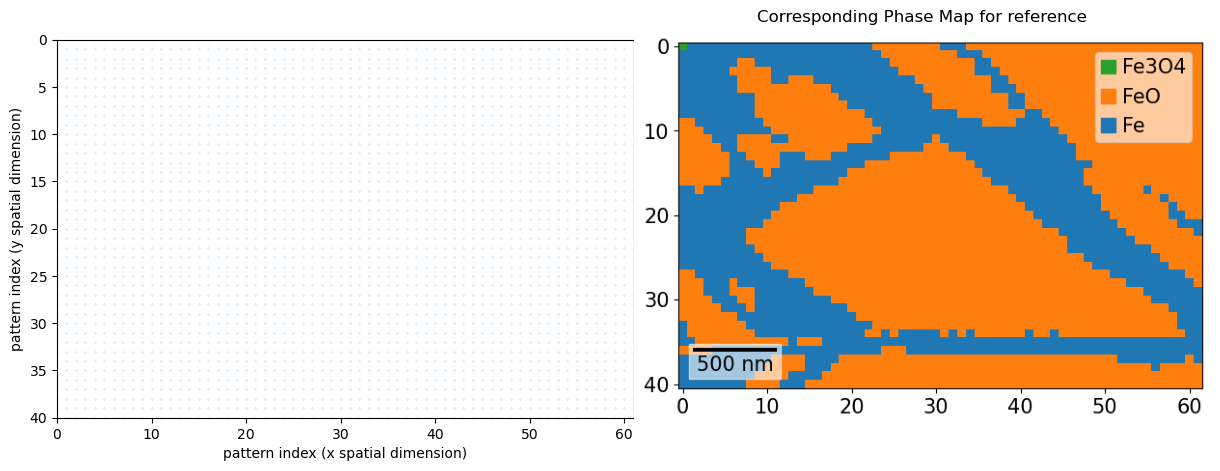

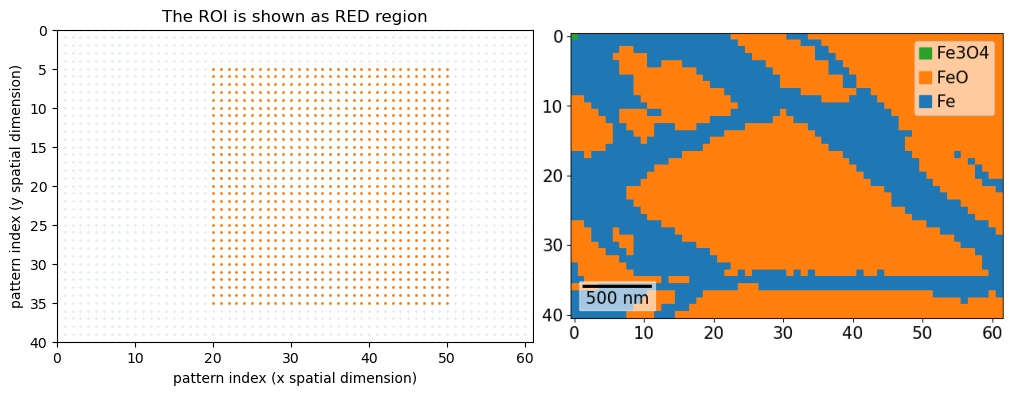

In [2]:
data_path = "../EBSD_scan"

fname_ang = data_path + "/Scan3_cropped.ang"
xmap = io.load(fname_ang)

edax_binary_path = data_path + "/Scan3_cropped.up1"

s_edax = kp.load(edax_binary_path)


xmap.phases[1].space_group = 227
xmap.phases[2].space_group = 225
xmap.phases[3].space_group = 229

xmap.prop["iq"] = xmap.prop.pop("unknown1")
xmap.prop["ci"] = xmap.prop.pop("unknown2")
xmap.prop["sem"] = xmap.prop.pop("unknown3")
xmap.prop["fit"] = xmap.prop.pop("unknown4")
xmap.prop["bs"] = xmap.prop.pop("unknown5")
xmap.prop["cs"] = xmap.prop.pop("unknown6")
xmap.prop["ts"] = xmap.prop.pop("unknown7")
xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
xmap.prop["Mg"] = xmap.prop.pop("unknown9")
xmap.prop["Al"] = xmap.prop.pop("unknown10")
xmap.prop["Si"] = xmap.prop.pop("unknown11")
xmap.prop["Ti"] = xmap.prop.pop("unknown12")
xmap.prop["Mn"] = xmap.prop.pop("unknown13")
xmap.prop["Fe"] = xmap.prop.pop("unknown14")

s_edax.xmap = xmap
s_edax.xmap.phases

path = "../EBSD_scan/"
grid = read_data(path)

# set roi, get the serial number of ebsp in roi (for getting the phase index later)
R6, loc = set_ROI((20,50),(5,35), path, grid)
loc = np.array(loc)
# dict {x,y} coordinates: phase index (all included)
coor_dict = coord_xmap_dict(s_edax.inav[20:51,5:36].xmap,0.05)

In [3]:
# make the (x,y) coordinates be a tuple
loc_tuples = [tuple(xy) for xy in loc]

[########################################] | 100% Completed | 114.91 ms
[########################################] | 100% Completed | 148.91 ms
[########################################] | 100% Completed | 114.52 ms
[########################################] | 100% Completed | 118.82 ms
[########################################] | 100% Completed | 118.21 ms
[########################################] | 100% Completed | 121.09 ms
[########################################] | 100% Completed | 111.75 ms
[########################################] | 100% Completed | 111.28 ms
[########################################] | 100% Completed | 126.88 ms
[########################################] | 100% Completed | 113.70 ms
[########################################] | 100% Completed | 118.43 ms
[########################################] | 100% Completed | 116.41 ms
[########################################] | 100% Completed | 121.36 ms
[########################################] | 100% Completed | 12

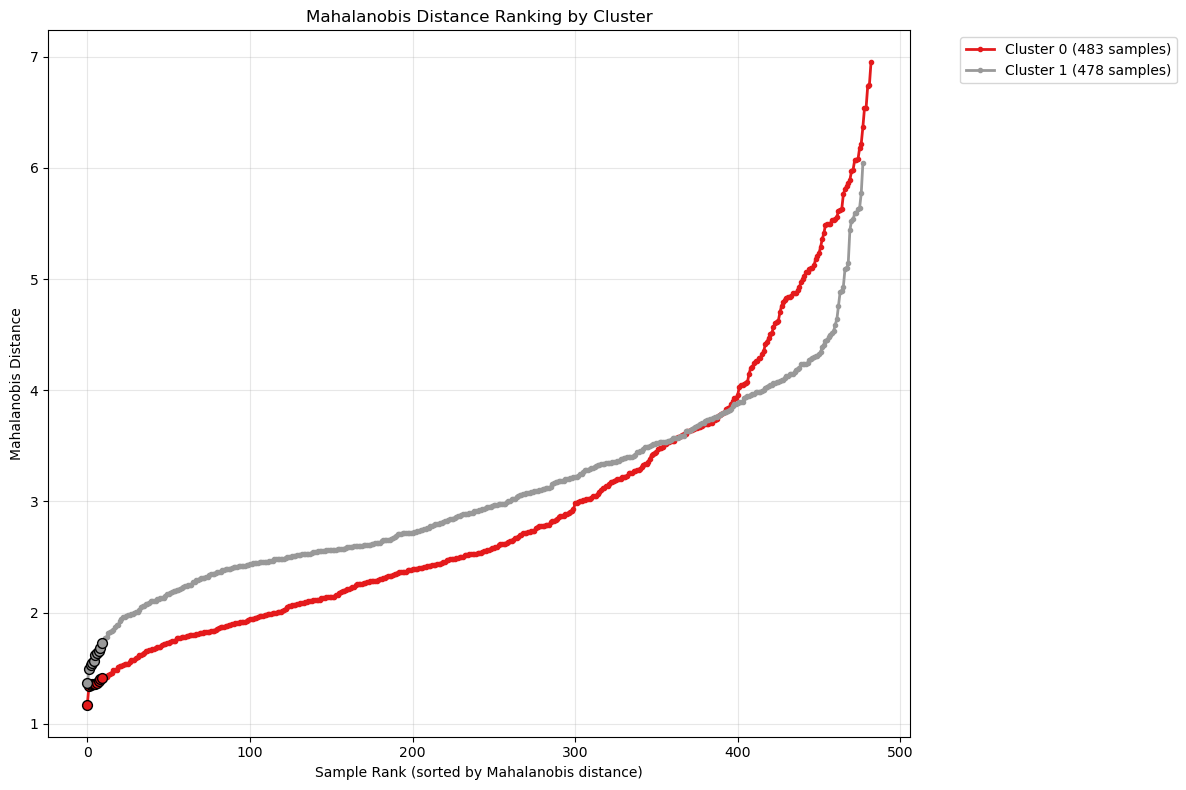

Top samples per cluster:
Cluster 0: 10 samples
  Distance range: 1.1717 - 1.4073
  Coordinates: [[29 27]
 [33 25]
 [24 25]]...

Cluster 1: 10 samples
  Distance range: 1.3618 - 1.7285
  Coordinates: [[32 12]
 [41 16]
 [48 16]]...

Best Reference Windows per Cluster:
Cluster 0:
  Center Location: [29 27]
  Metric Value: 1.7666 (w1=1, w2=1)
  Window Mean Distance: 1.6862
  Window Variance: 0.0804
----------------------------------------
Cluster 1:
  Center Location: [41 16]
  Metric Value: 1.9042 (w1=1, w2=1)
  Window Mean Distance: 1.8374
  Window Variance: 0.0667
----------------------------------------


In [4]:
# weights for each component
pca_scores1, pca = run_PCA(R6, 10)
df = pd.DataFrame(pca_scores1, index= loc_tuples)
df.to_csv("pca_scores1.csv")

gmm_model2, cluster_coords_c2, cluster_labels2, optimal_n, silhouette = gmm_clustering(pca_scores1,loc, None, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")

coord_to_label2 = {}
for label, coords_list in cluster_coords_c2.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label2[coord_tuple] = label
anomalies_cluster_pca_scores2, anomalies_cluster_pca_coords2, anomalies_labels_pca2 = detect_anomalies_pca(pca_scores1, coord_to_label2, loc)
anomalies_coord_label_dict2 = {}
for i in range(len(anomalies_labels_pca2)):
    coord = tuple(anomalies_cluster_pca_coords2[i])
    anomalies_coord_label_dict2[coord] = anomalies_labels_pca2[i]
centers2, covs2, variations2 = calculate_cluster_metrics(gmm_model2, cluster_labels2, pca_scores1)

top_samples_per_cluster2= plot_cluster_distances_ranking(gmm_model2, cluster_labels2, pca_scores1, loc)
best_window2 = find_best_reference_window(top_samples_per_cluster2, cluster_labels2, variations2, loc)

The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 221.19 ms
[########################################] | 100% Completed | 114.47 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 119.15 ms
[########################################] | 100% Completed | 111.76 ms


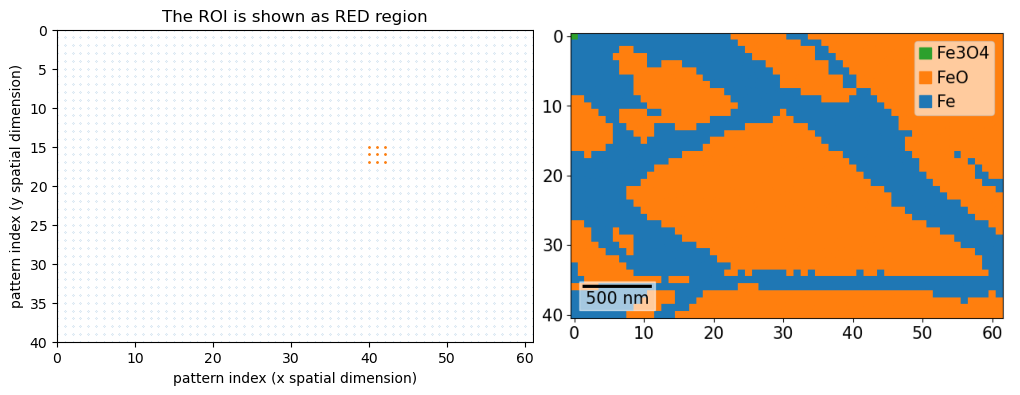

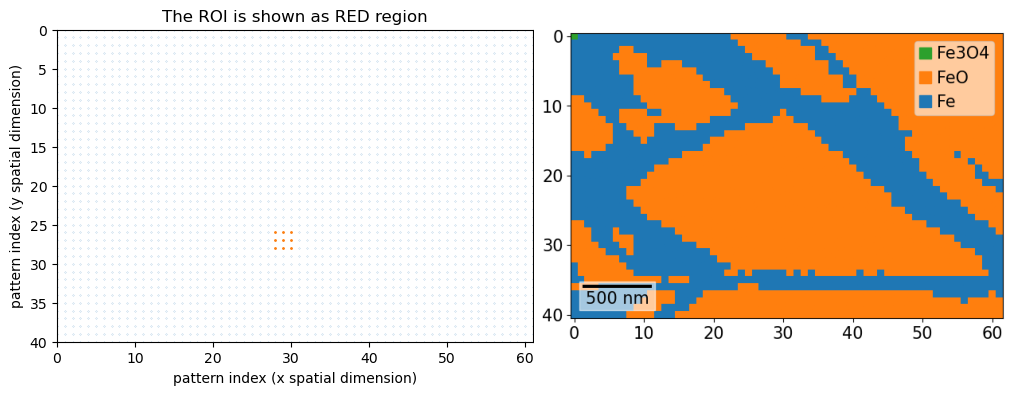

In [4]:
# set components
x_range_7 = (40,42)
y_range_7 = (15,17)
R7, ref7_pos = set_component(x_range_7, y_range_7, path, grid)


x_range_8 = (28,30)
y_range_8 = (26,28)
R8, ref8_pos = set_component(x_range_8, y_range_8, path, grid)


components = get_components(R7, R8)

The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 216.76 ms
[########################################] | 100% Completed | 111.49 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 111.52 ms
[########################################] | 100% Completed | 111.85 ms
[########################################] | 100% Completed | 110.17 ms
[########################################] | 100% Completed | 112.75 ms
[########################################] | 100% Completed | 116.46 ms
[########################################] | 100% Completed | 115.55 ms
[########################################] | 100% Completed | 116.66 ms
[########################################] | 100% Completed | 114.91 ms
[########################################] | 100% Completed | 121.92 ms
[########################################] | 100% Completed | 113.85 ms
[########################################] | 100% Completed 

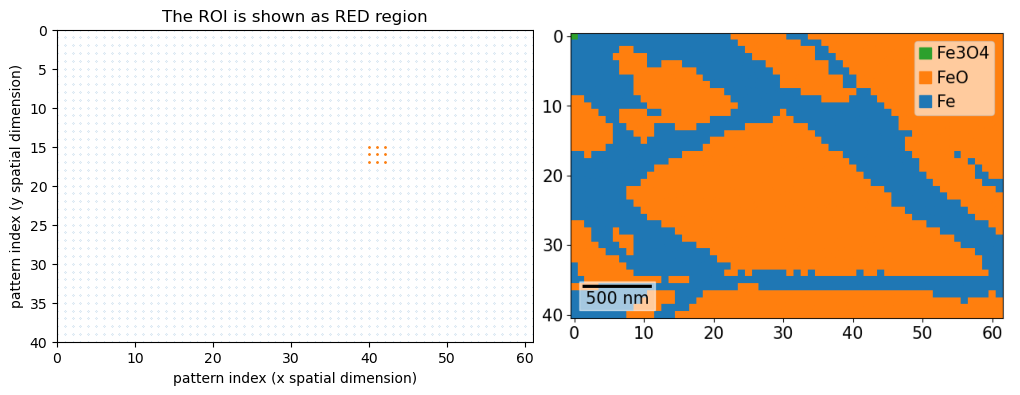

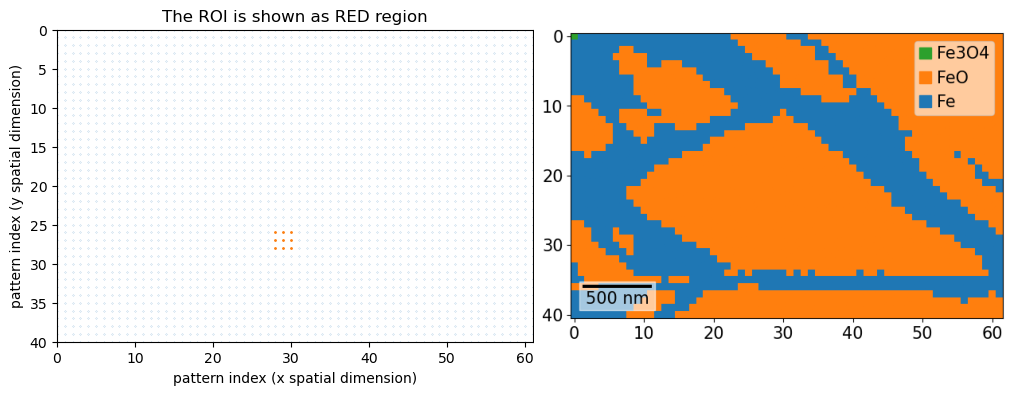

In [6]:
# run cNMF
weights1,mse,r_square = run_cNMF(R6, components)

df = pd.DataFrame(weights1, index=loc_tuples)
df.to_csv("weight1.csv")


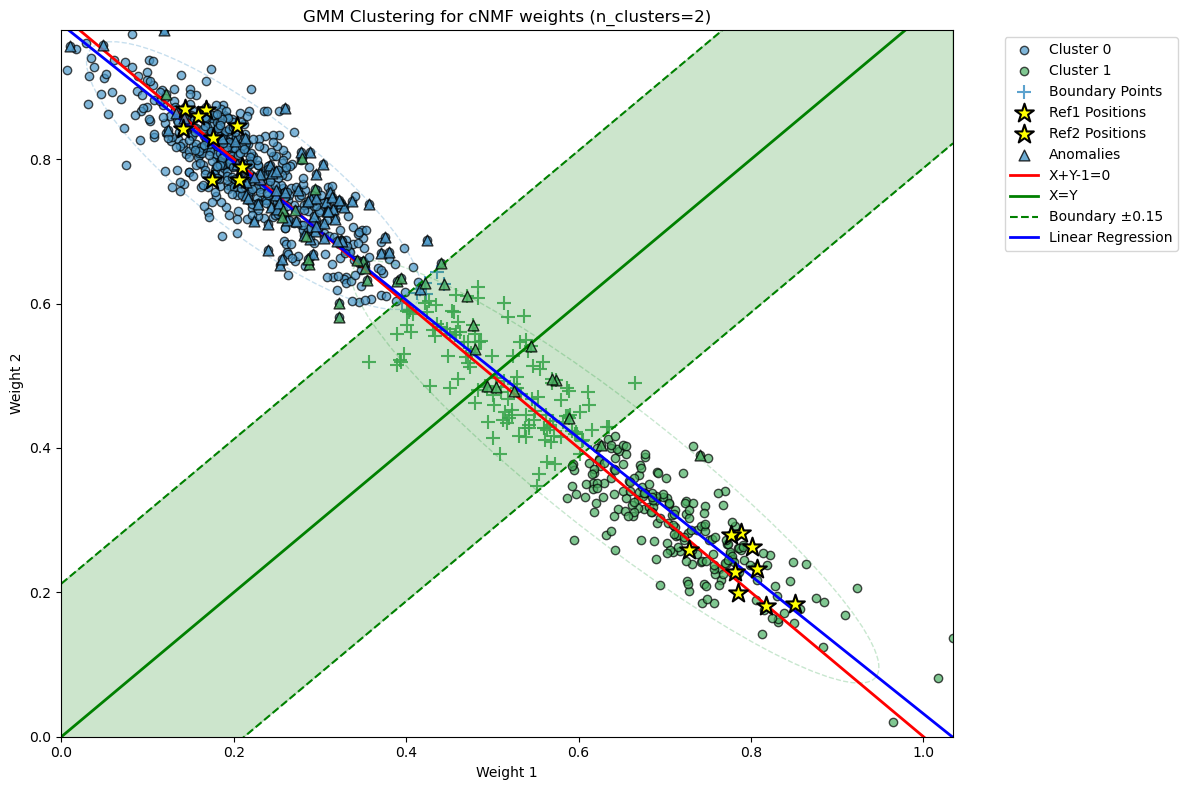

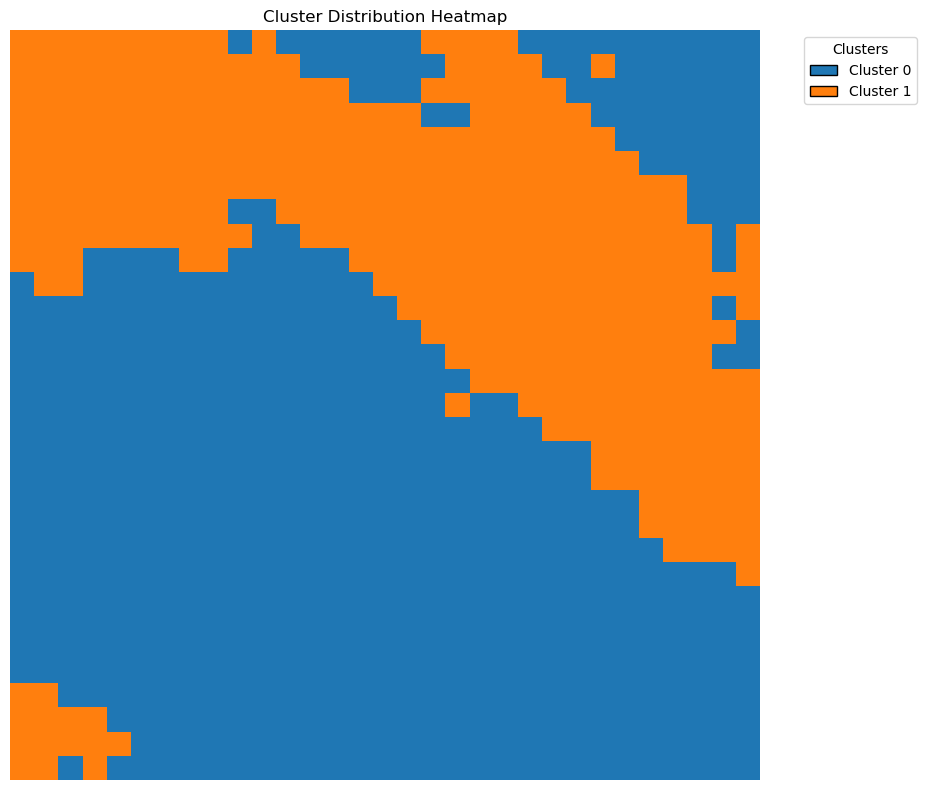

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
          Metric    Value
             ARI 0.527554
             NMI 0.411417
     homogeneity 0.423353
    completeness 0.400136
       v_measure 0.411417
   user_accuracy 0.864724
optimal_accuracy 0.864724

Optimal Cluster-to-Phase Mapping:
------------------------------------------------------------
 cluster  Samples User mapping Algorithm mapping
       0      603          FeO               FeO
       1      358           Fe                Fe

Confusion Matrix (After Mapping):
------------------------------------------------------------
           Pred: FeO  Pred: Fe
True: FeO        565        92
True: Fe          38       266


In [5]:
# gmm clustering for cNMF weights
gmm_model8, cluster_coords_cnmf8, cluster_labels_cnmf8, optimal_n, silhouette = gmm_clustering(weights1, loc, None, 10)

boundary_mask, boundary_scores, boundary_locs, boundary_labels, slope, intercept = plot_cnmf_scatter_with_boundary(weights1, loc, cluster_labels_cnmf8, optimal_n, ref7_pos, ref8_pos, anomalies_coord_label_dict2, d=0.15)

coord_to_label_cnmf8 = {}
for label, coords_list in cluster_coords_cnmf8.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label_cnmf8[coord_tuple] = label
boundary_coord_label_dict = {}
for i in range(len(boundary_labels)):
    coord = tuple(boundary_locs[i])
    boundary_coord_label_dict[coord] = boundary_labels[i]
    
plot_cluster_heatmap(cluster_coords_cnmf8,(31,31))

cluster_name_map = {
    0: 'FeO',
    1: 'Fe',
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
evaluate_results = evaluate_clustering_metrics(coor_dict, coord_to_label_cnmf8, name_map, cluster_name_map, True)

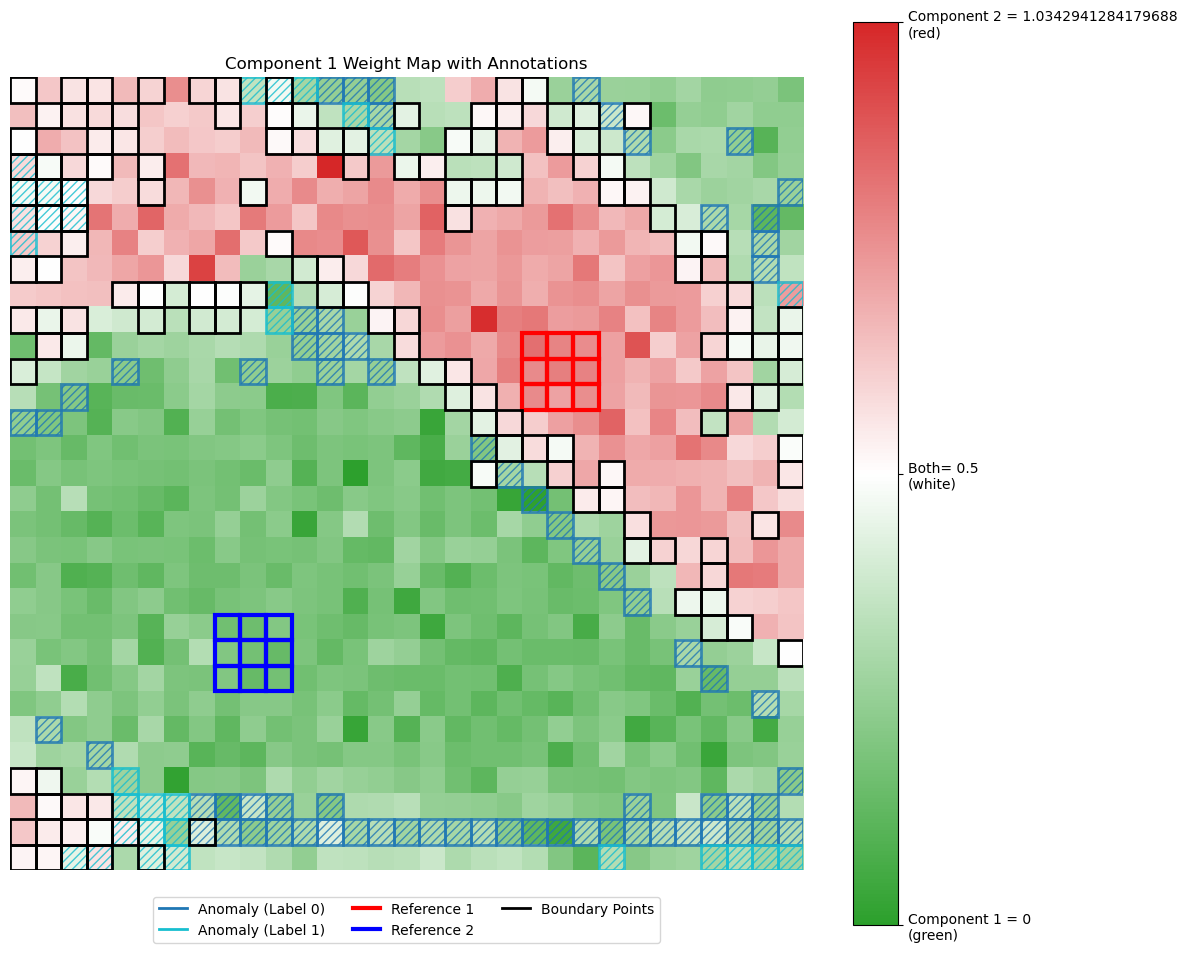

Similarity between anomalies and boundary points:
  Number of anomalies: 103
  Number of boundary points: 143
  Intersection: 13
  Jaccard Index: 0.0558
  Overlap Coefficient: 0.1262


In [6]:
jaccard, overlap_coefficient= plot_weight_map_cnmf_with_anomalies(weights1, loc, anomalies_coord_label_dict2, ref7_pos, ref8_pos, 0, boundary_locs)

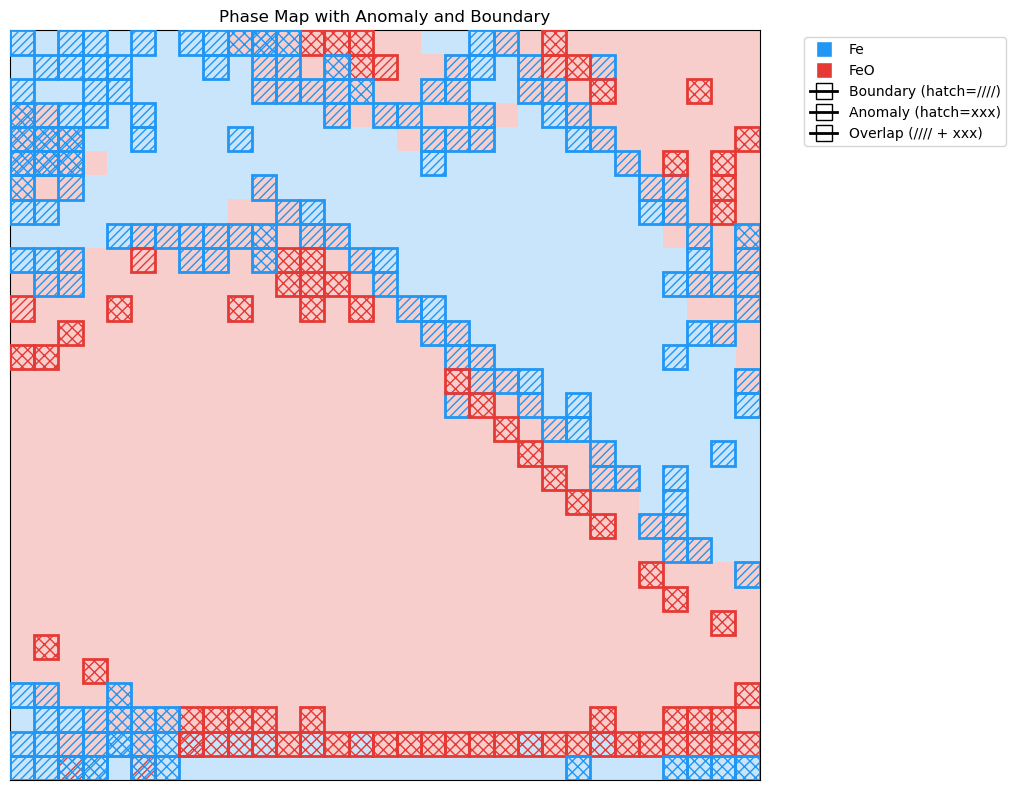

In [7]:
coor_phase_map= {2: 'FeO', 3:'Fe'}
boundary_loc_label_map={0: 'FeO', 1:'Fe'}
anomalies_loc_label_map={0: 'FeO', 1:'Fe'}
plot_phase_heatmap(coor_dict, boundary_coord_label_dict, anomalies_coord_label_dict2, coor_phase_map, boundary_loc_label_map, anomalies_loc_label_map, (31,31))

* > jaccard = len(set(A) & set(B)) / len(set(A) | set(B))
* > overlap = len(set(A) & set(B)) / min(len(set(A)), len(set(B)))

### 1.2 Artificial Noise (Gaussian noise)

In [3]:
noisy_images_array, output_paths= add_gaussian_noise_to_kikuchi_patterns(R6, 25, "./Noise_scan", True)

Processing 961 Kikuchi patterns...
Adding Gaussian noise with std=25 (only within circular signal region)
Output folder: ./Noise_scan


Adding noise: 100%|██████████| 961/961 [00:05<00:00, 174.50it/s]



Completed processing!
Generated 961 noisy images
Output shape: (961, 239, 239, 3)
Saved to: ./Noise_scan


x dimensions 62 
 y dimensions 41 
 in multiples of 1


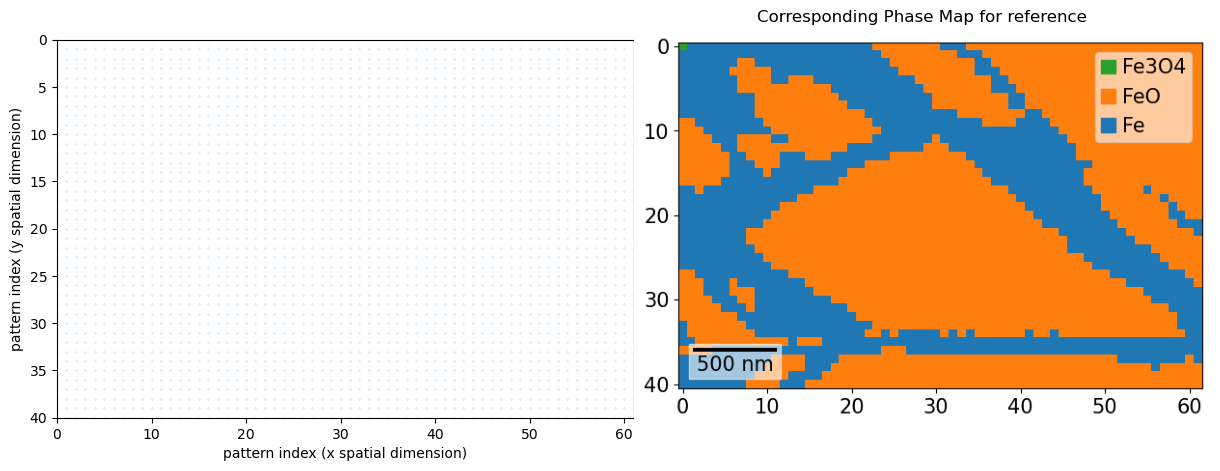

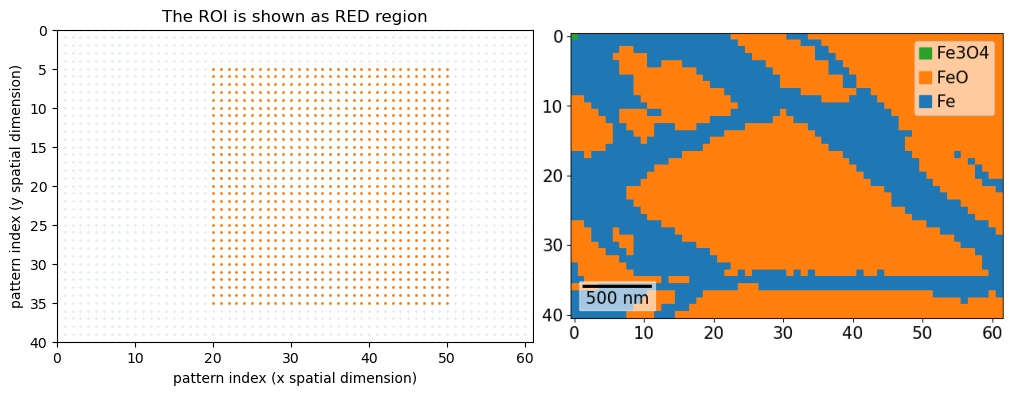

In [12]:
path = "./Noise_scan/"
grid = read_data(path)

# set roi, get the serial number of ebsp in roi (for getting the phase index later)
R11, loc_n = set_ROI((20,50),(5,35), path, grid)
loc_n = np.array(loc_n)

[                                        ] | 0% Completed | 1.30 ms

[########################################] | 100% Completed | 110.44 ms
[########################################] | 100% Completed | 117.47 ms
[########################################] | 100% Completed | 110.19 ms
[########################################] | 100% Completed | 120.48 ms
[########################################] | 100% Completed | 115.53 ms
[########################################] | 100% Completed | 114.04 ms
[########################################] | 100% Completed | 108.31 ms
[########################################] | 100% Completed | 108.32 ms
[########################################] | 100% Completed | 112.51 ms
[########################################] | 100% Completed | 110.79 ms
[########################################] | 100% Completed | 110.88 ms
[########################################] | 100% Completed | 114.57 ms
[########################################] | 100% Completed | 119.56 ms
[########################################] | 100% Completed | 11

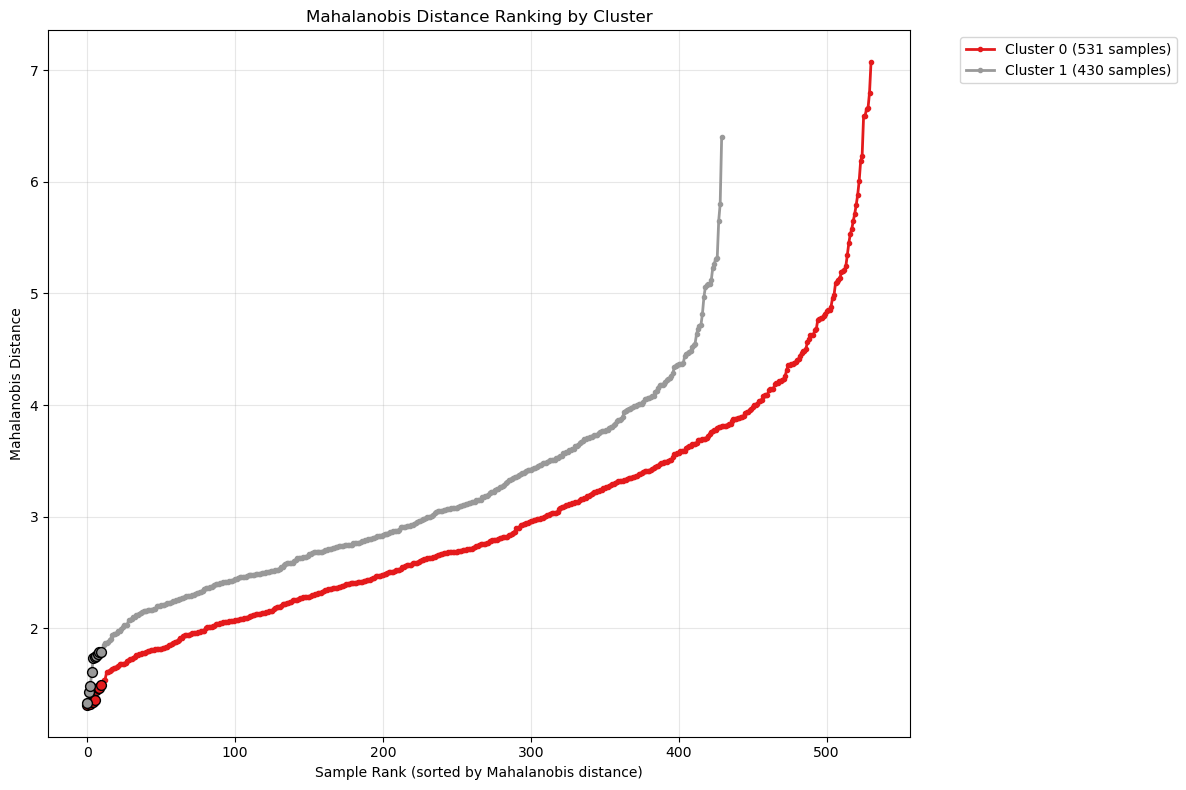

Top samples per cluster:
Cluster 0: 10 samples
  Distance range: 1.3164 - 1.4964
  Coordinates: [[41 31]
 [36 21]
 [28 16]]...

Cluster 1: 10 samples
  Distance range: 1.3269 - 1.7878
  Coordinates: [[41 16]
 [48 14]
 [41 17]]...

Best Reference Windows per Cluster:
Cluster 0:
  Center Location: [22 24]
  Metric Value: 2.3268 (w1=1, w2=1)
  Window Mean Distance: 2.0961
  Window Variance: 0.2307
----------------------------------------
Cluster 1:
  Center Location: [41 17]
  Metric Value: 2.1748 (w1=1, w2=1)
  Window Mean Distance: 1.9810
  Window Variance: 0.1938
----------------------------------------


In [10]:
# weights for each component
pca_scores, pca = run_PCA(R11, 10)

gmm_model3, cluster_coords_c3, cluster_labels3, optimal_n, silhouette = gmm_clustering(pca_scores,loc_n, 2, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")

coord_to_label3 = {}
for label, coords_list in cluster_coords_c3.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label3[coord_tuple] = label
anomalies_cluster_pca_scores3, anomalies_cluster_pca_coords3, anomalies_labels_pca3 = detect_anomalies_pca(pca_scores, coord_to_label3, loc_n)
anomalies_coord_label_dict3 = {}
for i in range(len(anomalies_labels_pca3)):
    coord = tuple(anomalies_cluster_pca_coords3[i])
    anomalies_coord_label_dict3[coord] = anomalies_labels_pca3[i]
centers3, covs3, variations3 = calculate_cluster_metrics(gmm_model3, cluster_labels3, pca_scores)


top_samples_per_cluster3= plot_cluster_distances_ranking(gmm_model3, cluster_labels3, pca_scores, loc_n)
best_window3 = find_best_reference_window(top_samples_per_cluster3, cluster_labels3, variations3, loc_n)

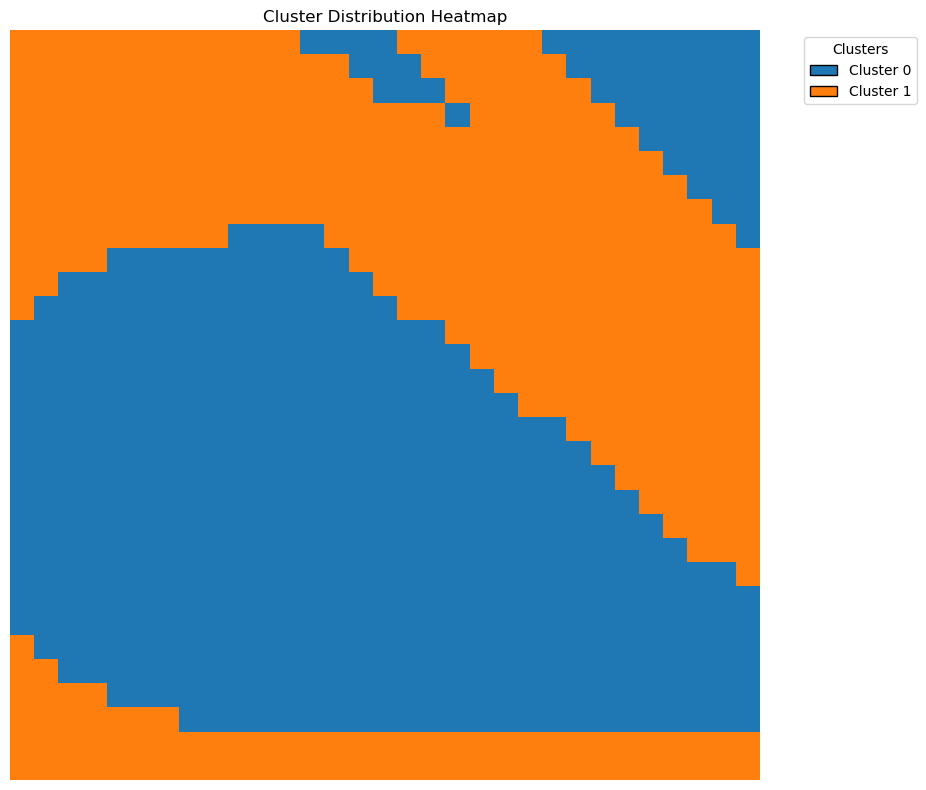

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
          Metric    Value
             ARI 0.543221
             NMI 0.538912
     homogeneity 0.566345
    completeness 0.514014
       v_measure 0.538912
   user_accuracy 0.868887
optimal_accuracy 0.868887

Optimal Cluster-to-Phase Mapping:
------------------------------------------------------------
 cluster  Samples User mapping Algorithm mapping
       0      531          FeO               FeO
       1      430           Fe                Fe

Confusion Matrix (After Mapping):
------------------------------------------------------------
           Pred: FeO  Pred: Fe
True: FeO        531       126
True: Fe           0       304
Cluster centers and corresponding labels: [(41, 31, 0), (41, 16, 1)]


d:\Material Files\PhD\kikuchi_cnmf\kikuchi-cnmf\micro_segmentation\cluster_analysis.py:620: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


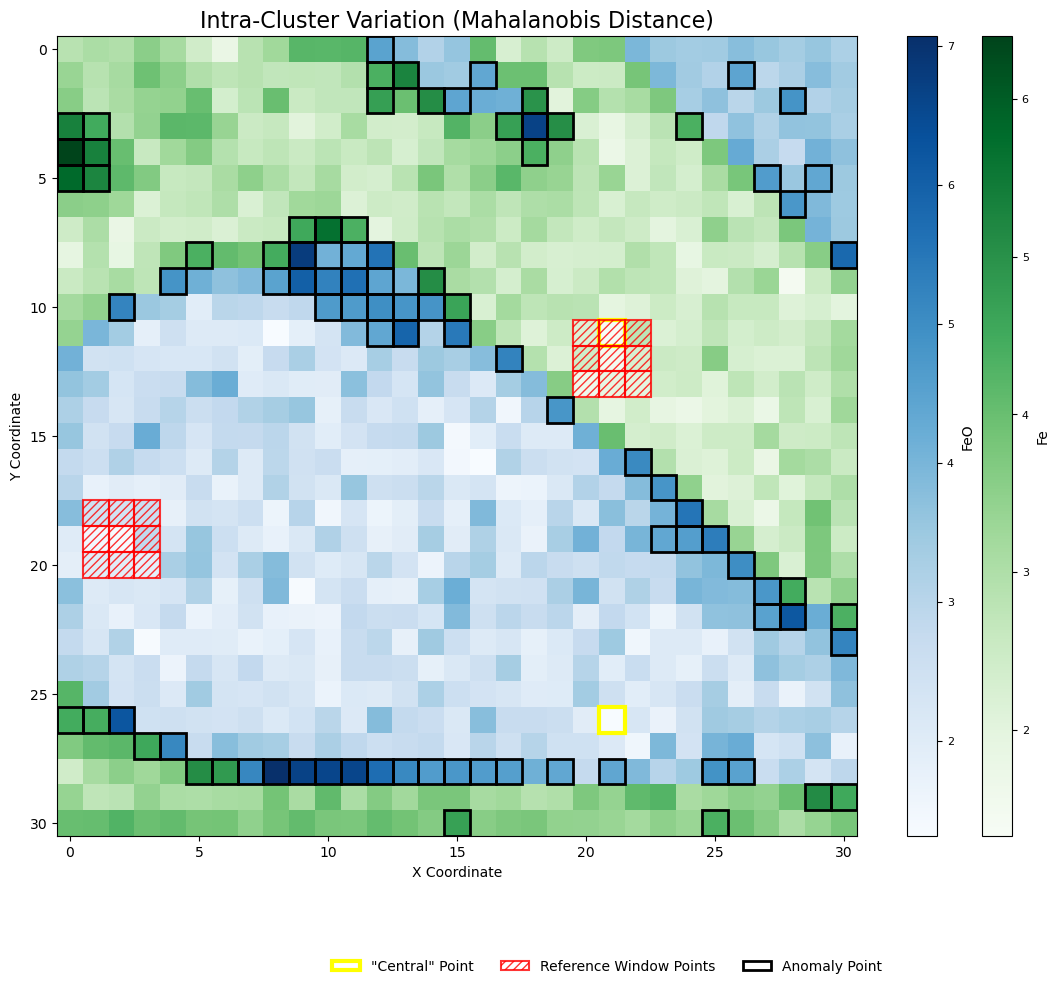

In [14]:
plot_cluster_heatmap(cluster_coords_c3,(31,31))
cluster_name_map = {
    0: 'FeO',
    1: 'Fe'
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}


evaluate_results = evaluate_clustering_metrics(coor_dict, coord_to_label3, name_map, cluster_name_map, True)

plot_intra_cluster_variation_map(loc_n, variations3, cluster_labels3, (31,31), None, cluster_name_map, anomalies_cluster_pca_coords3, None, None, best_window3)

The component C1 grid shape is (3, 3)
[                                        ] | 0% Completed | 1.78 ms

[########################################] | 100% Completed | 128.32 ms
[########################################] | 100% Completed | 107.08 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 112.13 ms
[########################################] | 100% Completed | 115.78 ms
[########################################] | 100% Completed | 107.92 ms
[########################################] | 100% Completed | 115.97 ms
[########################################] | 100% Completed | 109.92 ms
[########################################] | 100% Completed | 107.13 ms
[########################################] | 100% Completed | 116.62 ms
[########################################] | 100% Completed | 108.92 ms
[########################################] | 100% Completed | 105.92 ms
[########################################] | 100% Completed | 109.50 ms
[########################################] | 100% Completed | 107.95 ms
[#########################

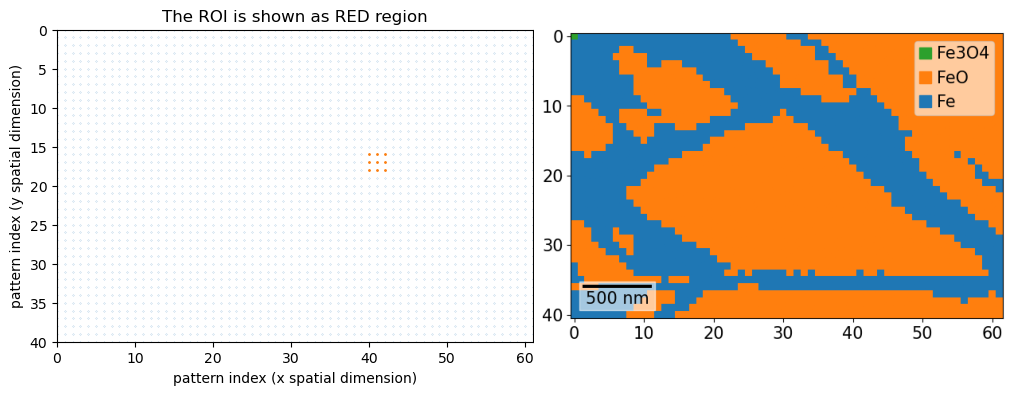

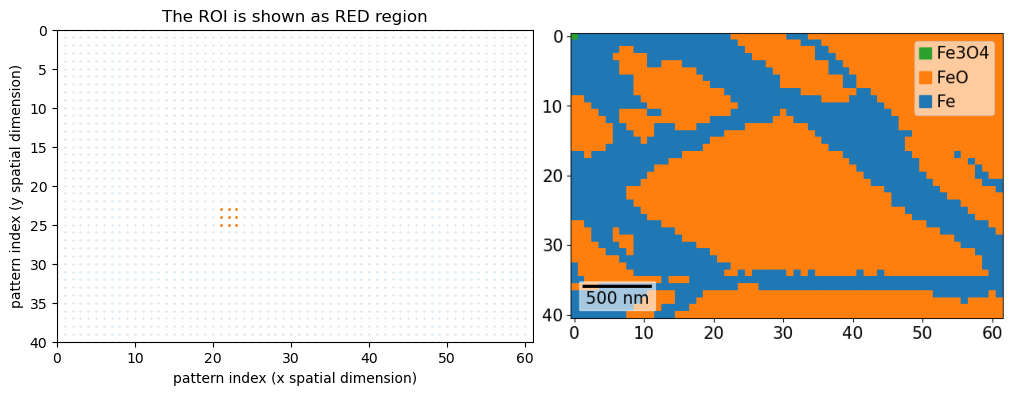

In [16]:
# set components
x_range_9 = (40,42)
y_range_9 = (16,18)
R9, ref9_pos = set_component(x_range_9, y_range_9, path, grid)


x_range_10 = (21,23)
y_range_10 = (23,25)
R10, ref10_pos = set_component(x_range_10, y_range_10, path, grid)

components = get_components(R9, R10)

# run cNMF
weights,mse,r_square = run_cNMF(R11, components)


Optimal clustering number: 2, silhouette: 0.607


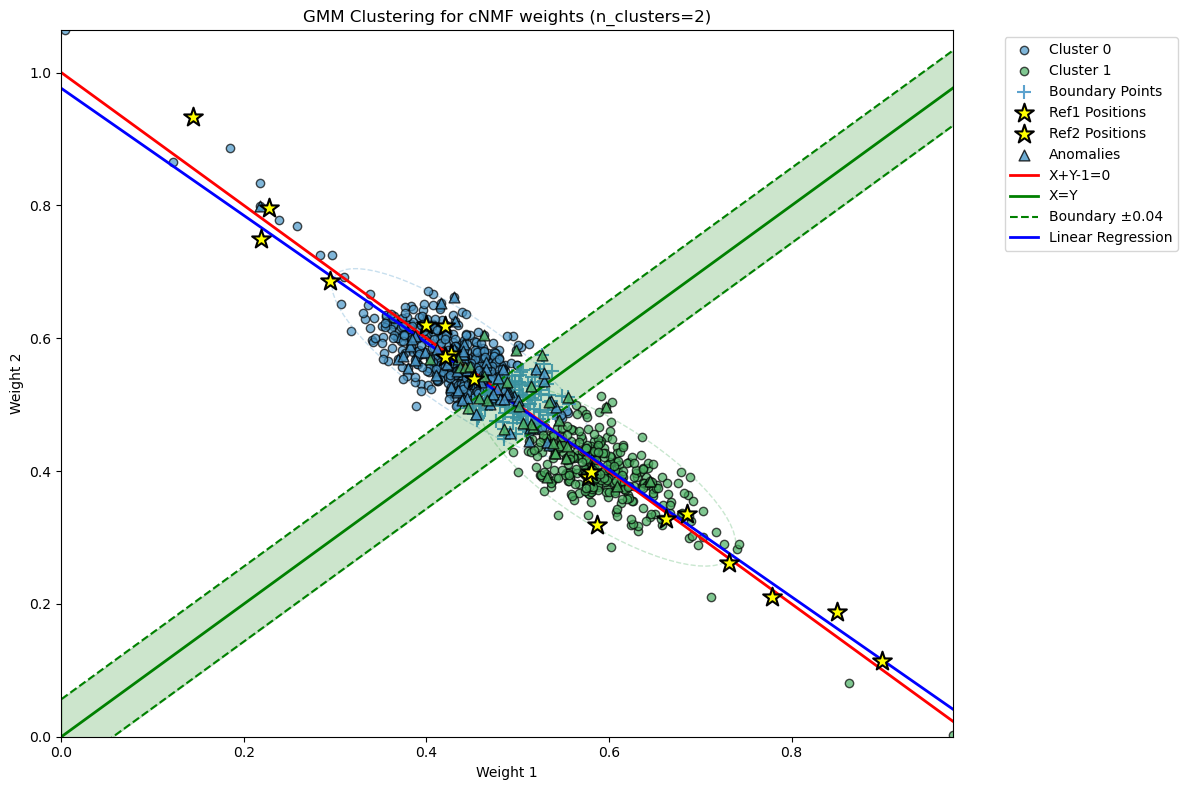

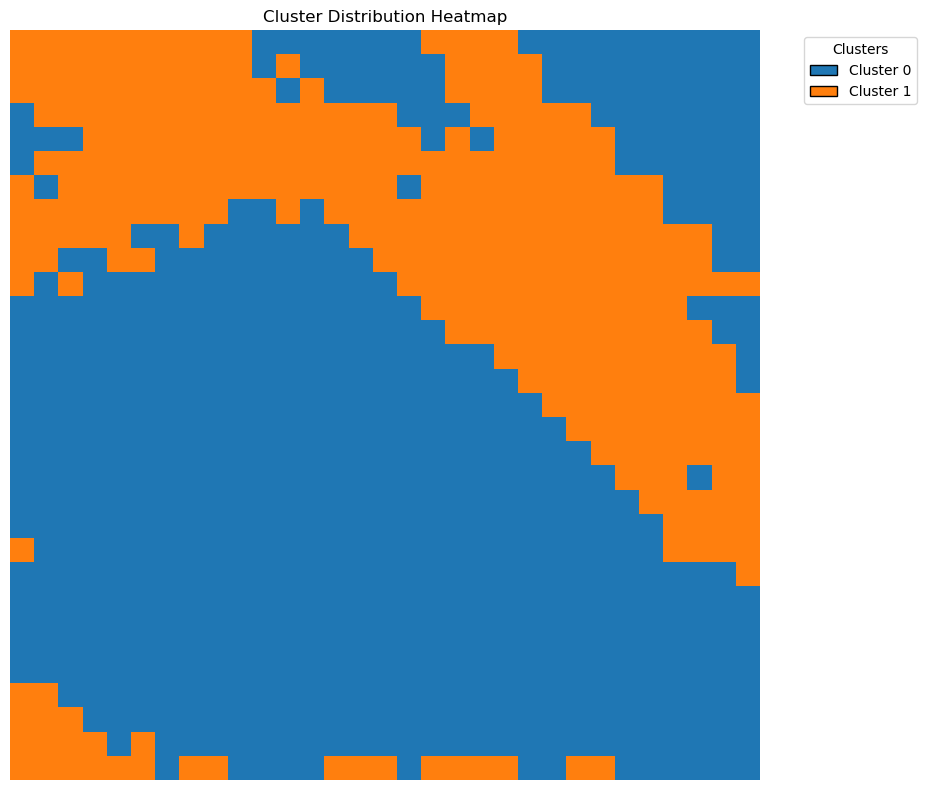

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
          Metric    Value
             ARI 0.704316
             NMI 0.576137
     homogeneity 0.583728
    completeness 0.568740
       v_measure 0.576137
   user_accuracy 0.920916
optimal_accuracy 0.920916

Optimal Cluster-to-Phase Mapping:
------------------------------------------------------------
 cluster  Samples User mapping Algorithm mapping
       0      635          FeO               FeO
       1      326           Fe                Fe

Confusion Matrix (After Mapping):
------------------------------------------------------------
           Pred: FeO  Pred: Fe
True: FeO        608        49
True: Fe          27       277


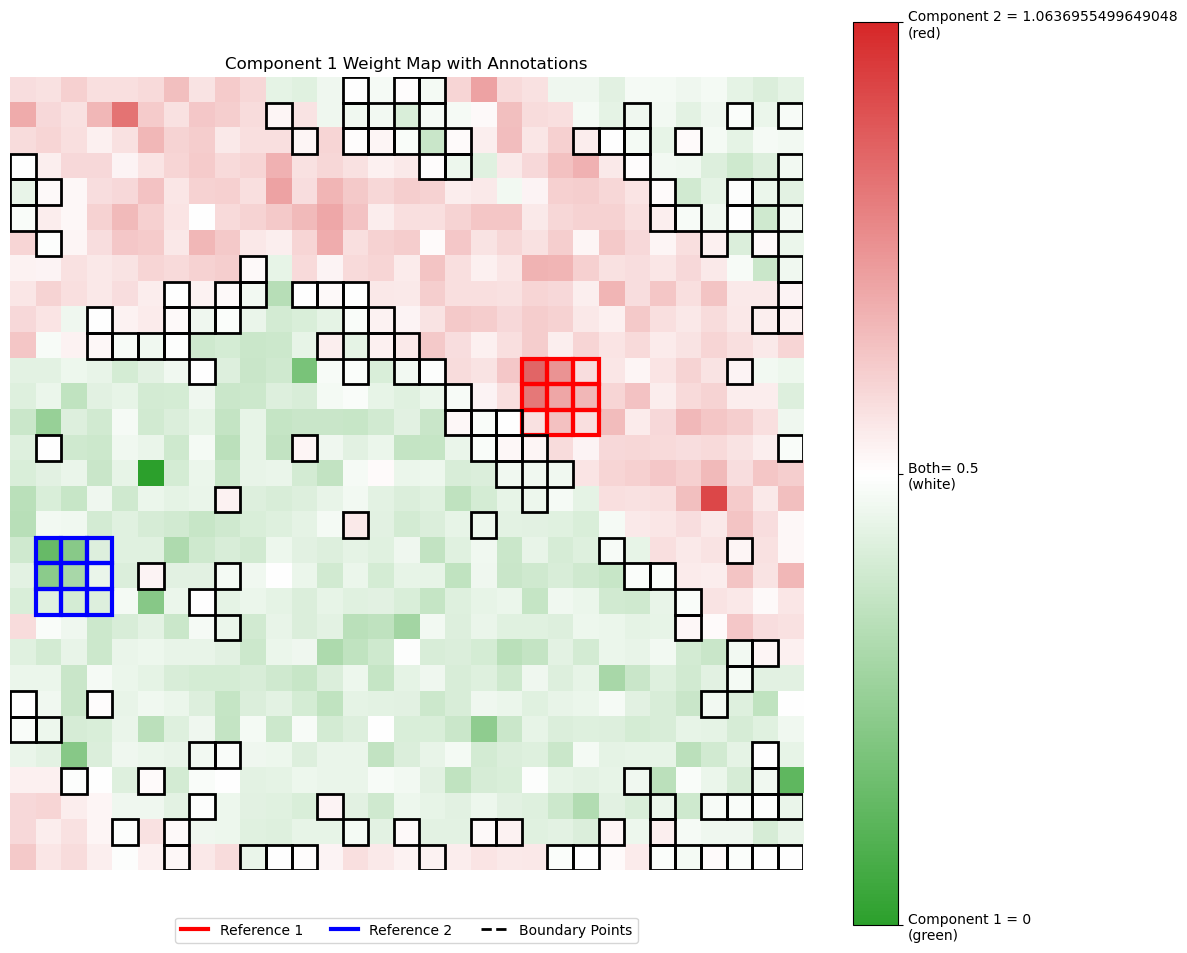

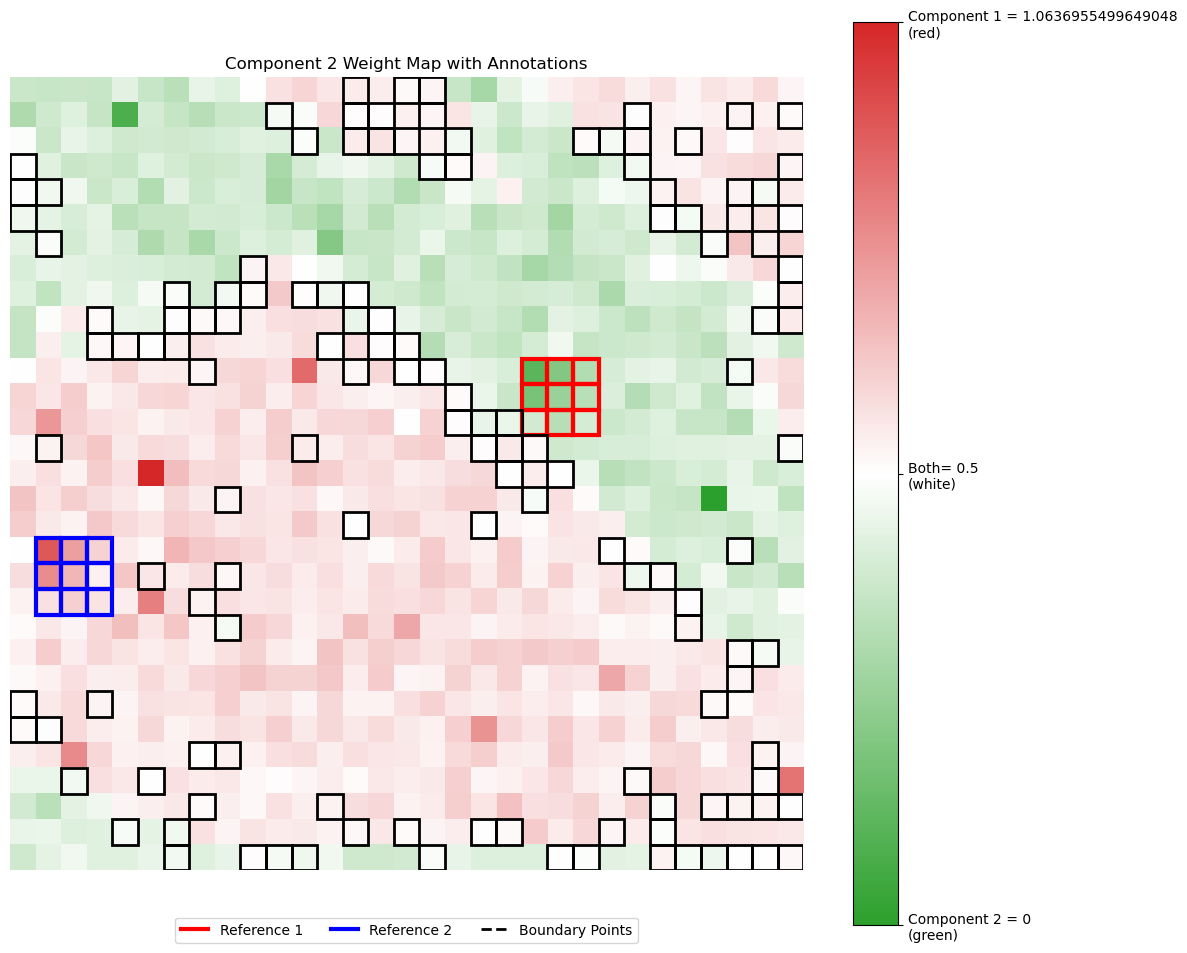

In [21]:
gmm_model4, cluster_coords_cnmf4, cluster_labels_cnmf4, optimal_n, silhouette = gmm_clustering(weights, loc_n, 2, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")

coord_to_label_cnmf4 = {}
for label, coords_list in cluster_coords_cnmf4.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label_cnmf4[coord_tuple] = label

boundary_mask2, boundary_scores2, boundary_locs2, boundary_labels2, slope, intercept = plot_cnmf_scatter_with_boundary(weights, loc_n, cluster_labels_cnmf4, optimal_n, ref9_pos, ref10_pos, anomalies_coord_label_dict3, d=0.04)

boundary_coord_label_dict2 = {}
for i in range(len(boundary_labels2)):
    coord = tuple(boundary_locs2[i])
    boundary_coord_label_dict2[coord] = boundary_labels2[i]
plot_cluster_heatmap(cluster_coords_cnmf4,(31,31))

cluster_name_map = {
    0: 'FeO',
    1: 'Fe',
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
evaluate_results = evaluate_clustering_metrics(coor_dict, coord_to_label_cnmf4, name_map, cluster_name_map, True)

plot_weight_map_cnmf(weights, loc, None, ref9_pos, ref10_pos, 0, boundary_locs2)
plot_weight_map_cnmf(weights, loc, None, ref9_pos, ref10_pos, 1, boundary_locs2)

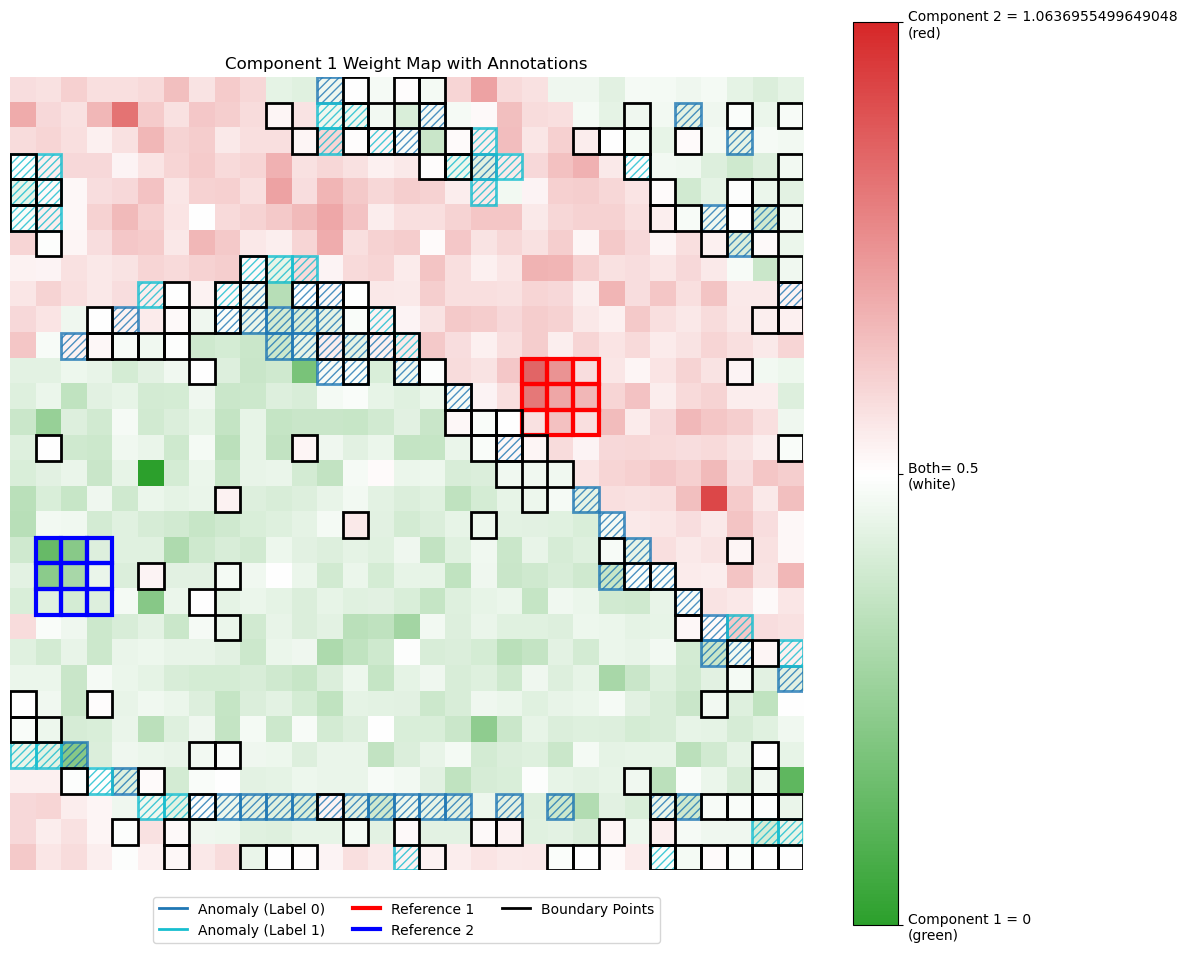

Similarity between anomalies and boundary points:
  Number of anomalies: 91
  Number of boundary points: 135
  Intersection: 33
  Jaccard Index: 0.1710
  Overlap Coefficient: 0.3626


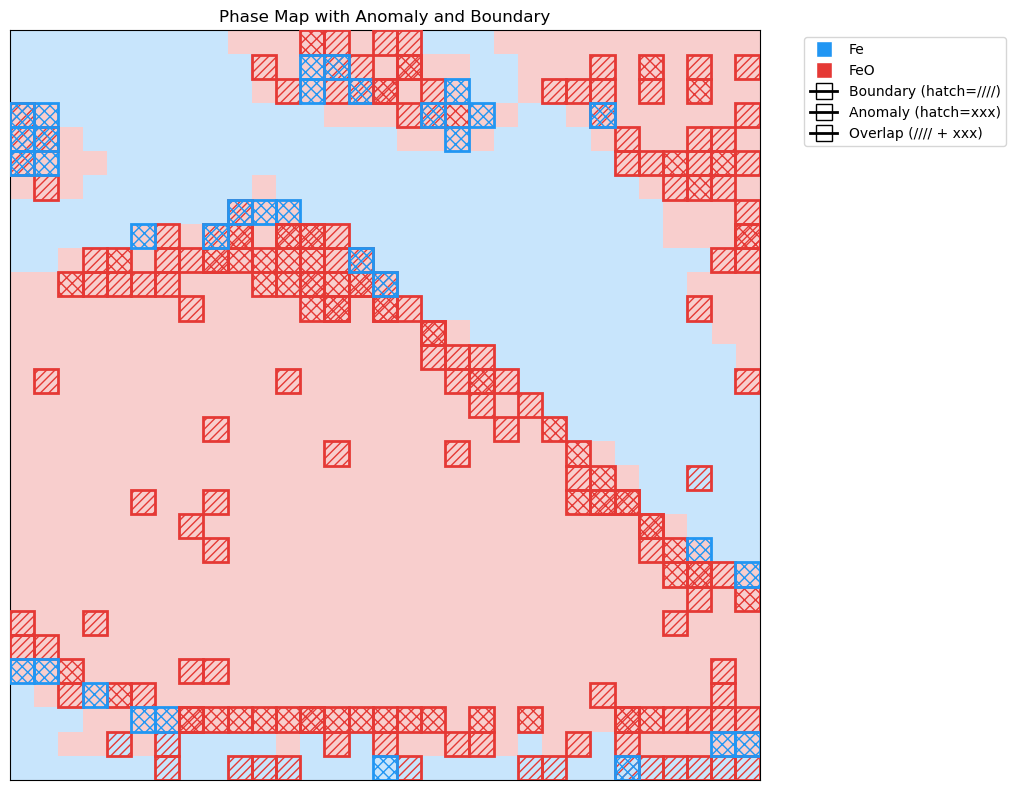

In [22]:
jaccard, overlap_coefficient= plot_weight_map_cnmf_with_anomalies(weights, loc_n, anomalies_coord_label_dict3, ref9_pos, ref10_pos, 0, boundary_coord_label_dict2)
coor_phase_map= {2: 'FeO', 3:'Fe'}
boundary_loc_label_map={0: 'FeO', 1:'Fe'}
anomalies_loc_label_map={0: 'FeO', 1:'Fe'}
plot_phase_heatmap(coor_dict, boundary_coord_label_dict2, anomalies_coord_label_dict3, coor_phase_map, boundary_loc_label_map, anomalies_loc_label_map, (31,31))

### 1.3 Correlations (Latent features/ weights/ pca scores/ X+Y-1/ Misorientation/ Mahalanobis)

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\orix\quaternion\quaternion.py:497: UserWarning: Angles are quite high, did you forget to set degrees=True?
  warnings.warn("Angles are quite high, did you forget to set degrees=True?")
d:\Material Files\PhD\kikuchi_cnmf\kikuchi-cnmf\micro_segmentation\process_indexing_data.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.95])


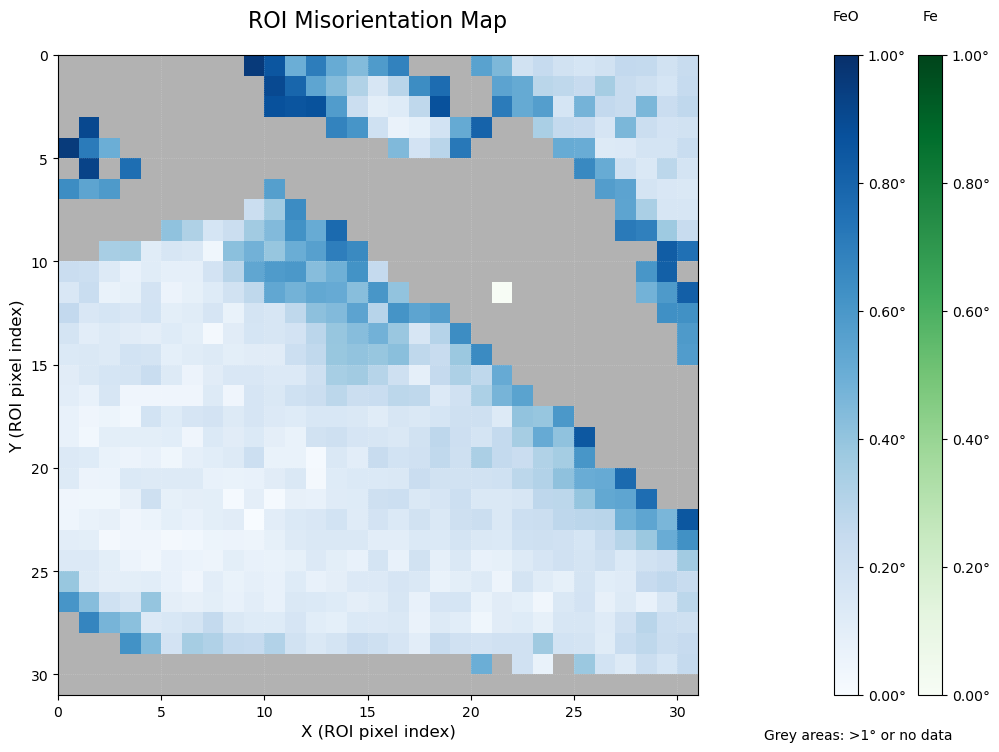

In [5]:
# misorientation calculated based on the orientation indexing (reference = window center)
roi_xrange=(20, 51)
roi_yrange=(5, 36)
phase_ref_points_relative={2: (9, 22), 3: (21, 11)}

result_table, mis_map, phase_map = compute_roi_misorientation_map_from_xmap(xmap, roi_xrange, roi_yrange, 0.05, phase_ref_points_relative, 1, None)

In [6]:
normalized_map, phase_min_max=normalize_misorientation_by_phase_map(mis_map, phase_map)
normalized_ori= normalized_map.reshape(-1,1).ravel()

In [7]:
# Mahalanobis/ EDS element
misorientation = pd.Series(normalized_ori, name='Misorientation')
latent2   = pd.read_csv('../vae_representation/latents_output_2feature.csv',   header=None, skiprows=1)  # shape (961,2)
latent4   = pd.read_csv('../vae_representation/latents_output_4feature.csv',   header=None, skiprows=1)  # shape (961,4)
latent8   = pd.read_csv('../vae_representation/latents_output_8feature.csv',   header=None, skiprows=1)  # shape (961,8)
latent16  = pd.read_csv('../vae_representation/latents_output_16feature.csv',  header=None, skiprows=1)  # shape (961,16)
pca_scores= pd.read_csv('pca_scores1.csv',  header=None, skiprows=1)  # shape (961,10)
pca_scores.iloc[:, 0] = pca_scores.iloc[:, 0].apply(
    lambda s: ast.literal_eval(s) if isinstance(s, str) else s
)
loc_p =pca_scores.iloc[:,0]
cnmf_w    = pd.read_csv('weight1.csv', header=None, skiprows=1) # shape (961,2)
pca_scores = pca_scores.iloc[:,1:]
cnmf_w = cnmf_w.iloc[:,1:]
cnmf_residual = cnmf_w[1] + cnmf_w[2] - 1

latent2.columns   = [f'L2_{i+1}'   for i in latent2.columns]
latent4.columns   = [f'L4_{i+1}'   for i in latent4.columns]
latent8.columns   = [f'L8_{i+1}'   for i in latent8.columns]
latent16.columns  = [f'L16_{i+1}'  for i in latent16.columns]
pca_scores.columns= [f'PC_{i+1}'   for i in pca_scores.columns]
cnmf_w.columns    = ['W1', 'W2']
cnmf_residual.name = 'W1+W2-1'


In [8]:
pca_scores1 = np.array(pca_scores)
weights1 = np.array(cnmf_w)

In [8]:
roi_eds = get_eds_average(roi_xrange, roi_yrange, s_edax, 'roi')
def normalize_roi_data_vectorized(roi_data):
    row_sums = np.nansum(roi_data, axis=1)

    row_sums[row_sums == 0] = 1
    
    normalized_data = roi_data / row_sums[:, np.newaxis]
    
    all_nan_rows = np.all(np.isnan(roi_data), axis=1)
    normalized_data[all_nan_rows] = 0
    
    return normalized_data
roi_eds = normalize_roi_data_vectorized(roi_eds)
roi_eds = pd.DataFrame(roi_eds, columns=['O', 'Mg', 'Al', 'Si', 'Ti', 'Mn', 'Fe'])
ref_coord_window = {0:(29,27), 1:(41,16)}
# m_distance = compute_mahalanobis_to_reference(pca_scores1, loc, cluster_labels2, ref_coord_window)
# m_distance = pd.Series(m_distance, name='mahalanobis')

In [25]:
df_all = pd.concat([
    pca_scores, cnmf_w, cnmf_residual, misorientation, roi_eds, m_distance
], axis=1)

In [26]:
# Pearson correlation and spearman correlation
pearson_corr  = df_all.corr(method='pearson')
spearman_corr = df_all.corr(method='spearman')

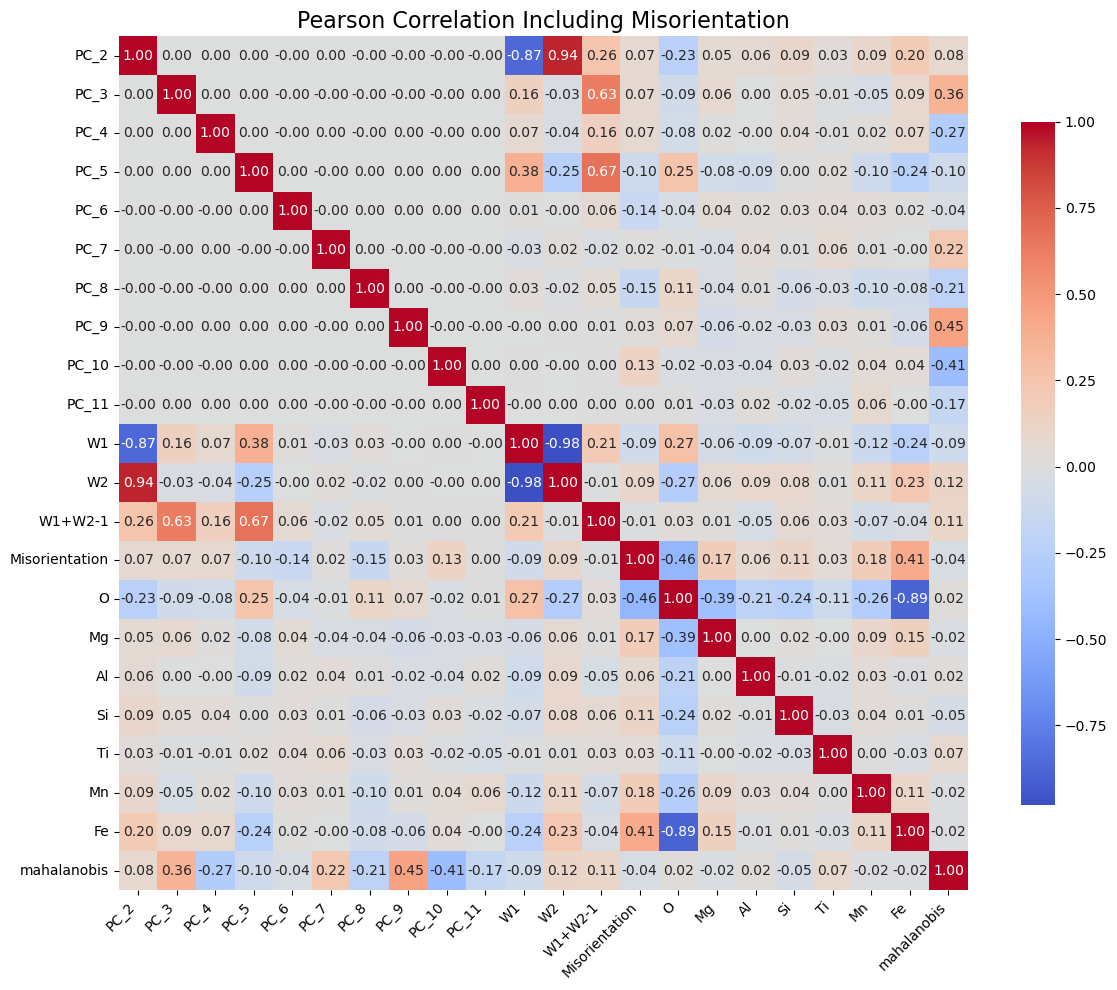

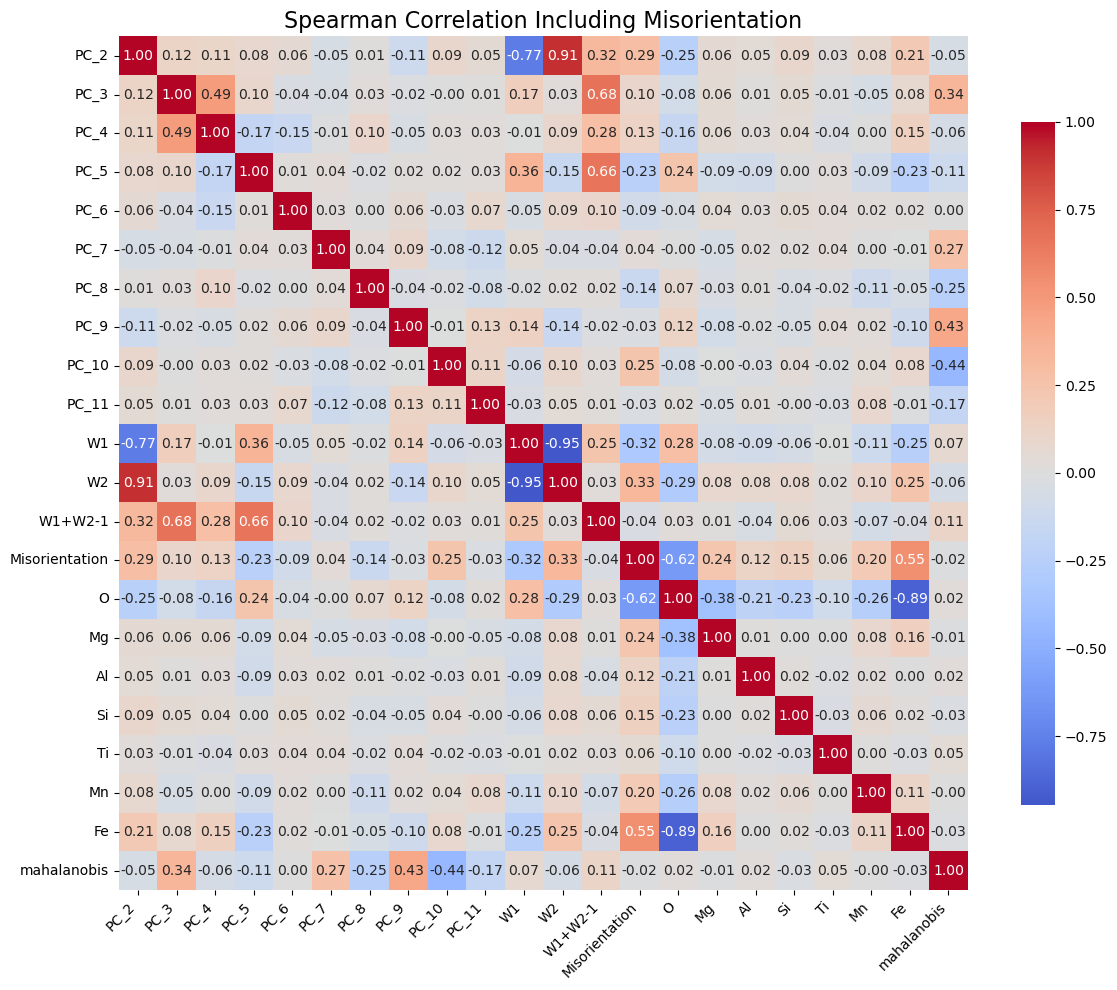

In [27]:
def plot_corr_heatmap(corr, title):
    plt.figure(figsize=(12,10))
    sns.heatmap(
        corr, annot=True, fmt='.2f',
        cmap='coolwarm', center=0,
        cbar_kws={'shrink':.8}
    )
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(pearson_corr,  'Pearson Correlation Including Misorientation')
plot_corr_heatmap(spearman_corr, 'Spearman Correlation Including Misorientation')

In [36]:
print("Top positive Pearson correlations with Misorientation:")
print(
    pearson_corr['Misorientation']
    .drop('Misorientation')
    .sort_values(ascending=False)
    .head(5)
)
print("\nTop negative Pearson correlations with Misorientation:")
print(
    pearson_corr['Misorientation']
    .drop('Misorientation')
    .sort_values()
    .head(5)
)

Top positive Pearson correlations with Misorientation:
PC_8    0.306317
O       0.301030
PC_4    0.163937
W1      0.159401
PC_9    0.151924
Name: Misorientation, dtype: float64

Top negative Pearson correlations with Misorientation:
Fe     -0.267524
W2     -0.166491
PC_1   -0.143622
PC_2   -0.109446
PC_5   -0.108874
Name: Misorientation, dtype: float64


### 1.4 Weighted Raw Kikuchi Patterns

[                                        ] | 0% Completed | 1.16 ms

[########################################] | 100% Completed | 111.59 ms
[########################################] | 100% Completed | 117.42 ms
[########################################] | 100% Completed | 107.27 ms
[########################################] | 100% Completed | 109.56 ms
[########################################] | 100% Completed | 109.06 ms
[########################################] | 100% Completed | 109.23 ms
[########################################] | 100% Completed | 113.87 ms
[########################################] | 100% Completed | 119.57 ms
[########################################] | 100% Completed | 116.90 ms
[########################################] | 100% Completed | 117.90 ms
[########################################] | 100% Completed | 122.99 ms
[########################################] | 100% Completed | 127.07 ms
[########################################] | 100% Completed | 118.52 ms
[########################################] | 100% Completed | 12

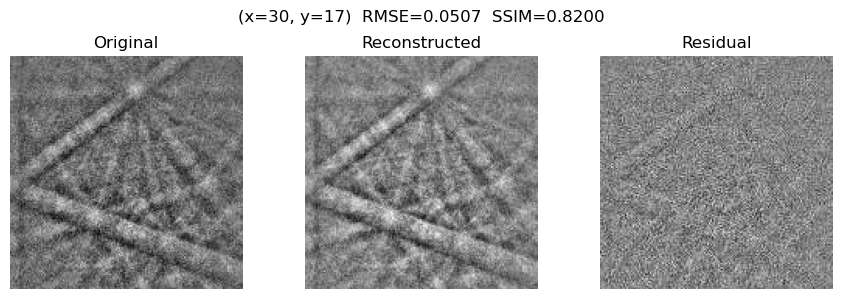

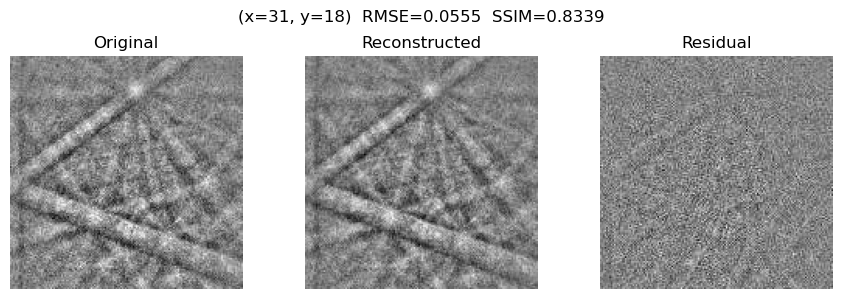

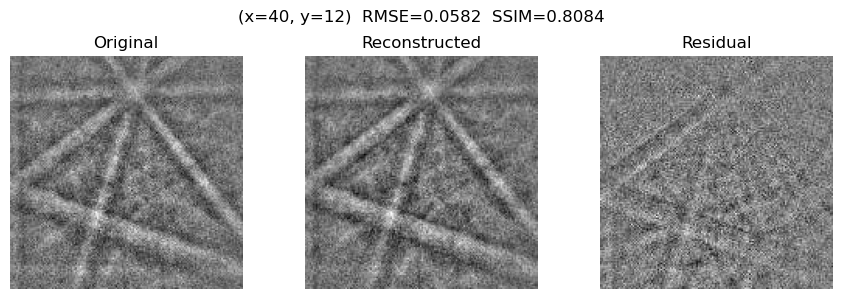

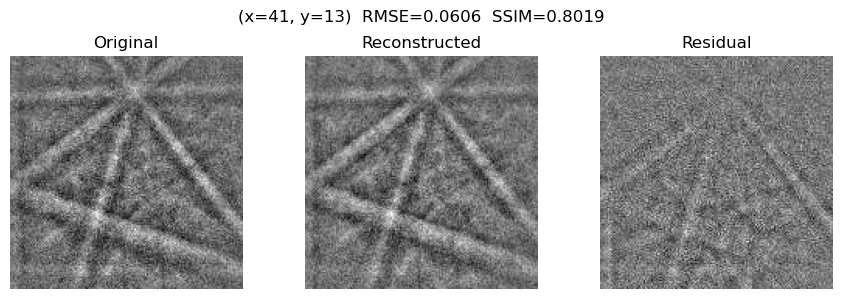

Done. CNMF reconstructions saved to: cnmf_reconstructed/reconstructed


In [9]:
# reconstruct_weighted_signals(R6, loc, weights1[:,0],'weighted_scan/',150,150)
residuals_cnmf, residual_norms_cnmf, rmses_cnmf, ssims_cnmf = reconstruct_weighted_signals(R6, loc, weights1,components,'cnmf_reconstructed/',150,150,[(30,17), (31,18),(40,12),(41,13)])

[                                        ] | 0% Completed | 770.90 us

[########################################] | 100% Completed | 108.32 ms
[########################################] | 100% Completed | 142.00 ms
[########################################] | 100% Completed | 110.25 ms
[########################################] | 100% Completed | 107.49 ms
[########################################] | 100% Completed | 105.55 ms
[########################################] | 100% Completed | 107.31 ms
[########################################] | 100% Completed | 108.19 ms
[########################################] | 100% Completed | 111.05 ms
[########################################] | 100% Completed | 109.84 ms
[########################################] | 100% Completed | 108.12 ms
[########################################] | 100% Completed | 107.58 ms
[########################################] | 100% Completed | 109.45 ms
[########################################] | 100% Completed | 109.22 ms
[########################################] | 100% Completed | 10

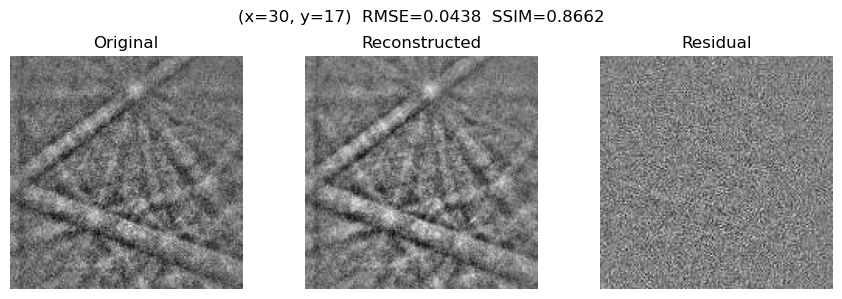

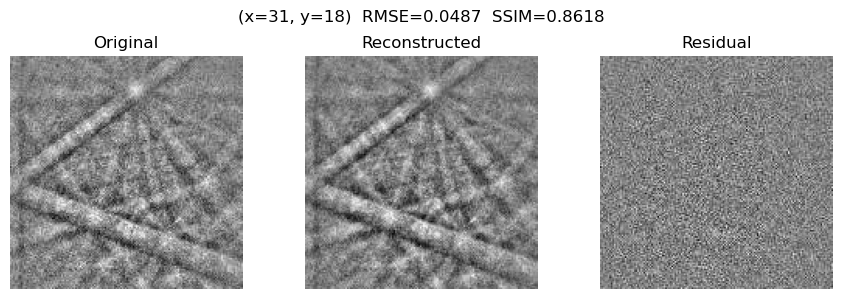

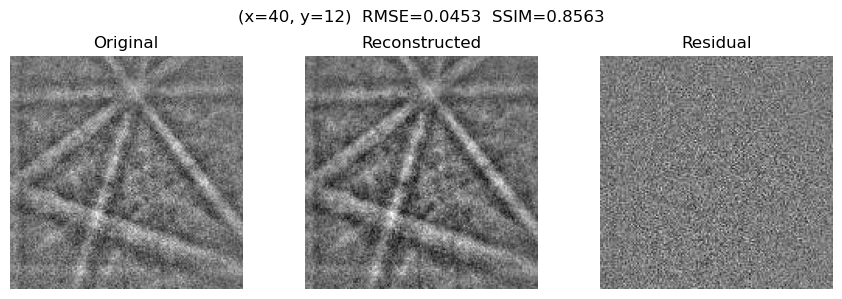

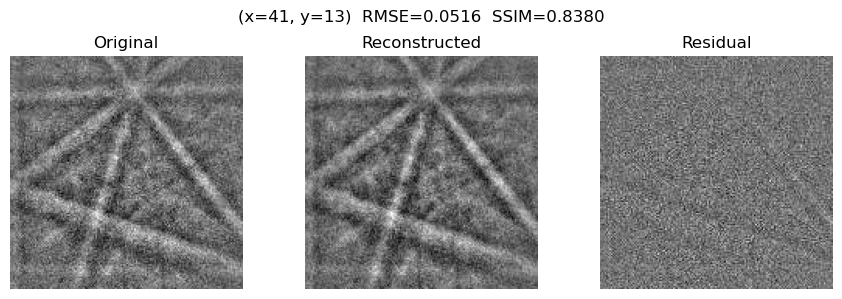

Done. Reconstructed images saved to: pca_reconstructed/reconstructed


In [14]:
# reconstruct_pca_signals(R6, loc, pca_scores1[:,0],'score_scan/',150,150)
residuals, residual_norms, rmses, ssims = reconstruct_pca_signals(R6, loc, pca_scores1, pca, 'pca_reconstructed/', 150,150, [(30,17), (31,18),(40,12),(41,13)])

### 1.5 PCA and element content

In [9]:
roi_eds

O        Mg        Al        Si        Ti        Mn        Fe
0    0.598795  0.030120  0.018072  0.032530  0.008434  0.010843  0.301205
1    0.599752  0.032838  0.024164  0.026022  0.013011  0.006196  0.298017
2    0.598148  0.038272  0.026543  0.031481  0.012346  0.012346  0.280864
3    0.606763  0.033813  0.033813  0.029430  0.008766  0.012523  0.274890
4    0.612080  0.028020  0.030511  0.021793  0.011831  0.008717  0.287049
..        ...       ...       ...       ...       ...       ...       ...
956  0.634741  0.028554  0.032719  0.027365  0.013087  0.008923  0.254610
957  0.617207  0.035536  0.019950  0.023691  0.013716  0.009352  0.280549
958  0.612325  0.031373  0.026891  0.029692  0.011765  0.010084  0.277871
959  0.614881  0.035714  0.027381  0.023214  0.011905  0.010714  0.276190
960  0.602596  0.038319  0.023486  0.027194  0.015451  0.014833  0.278121

[961 rows x 7 columns]

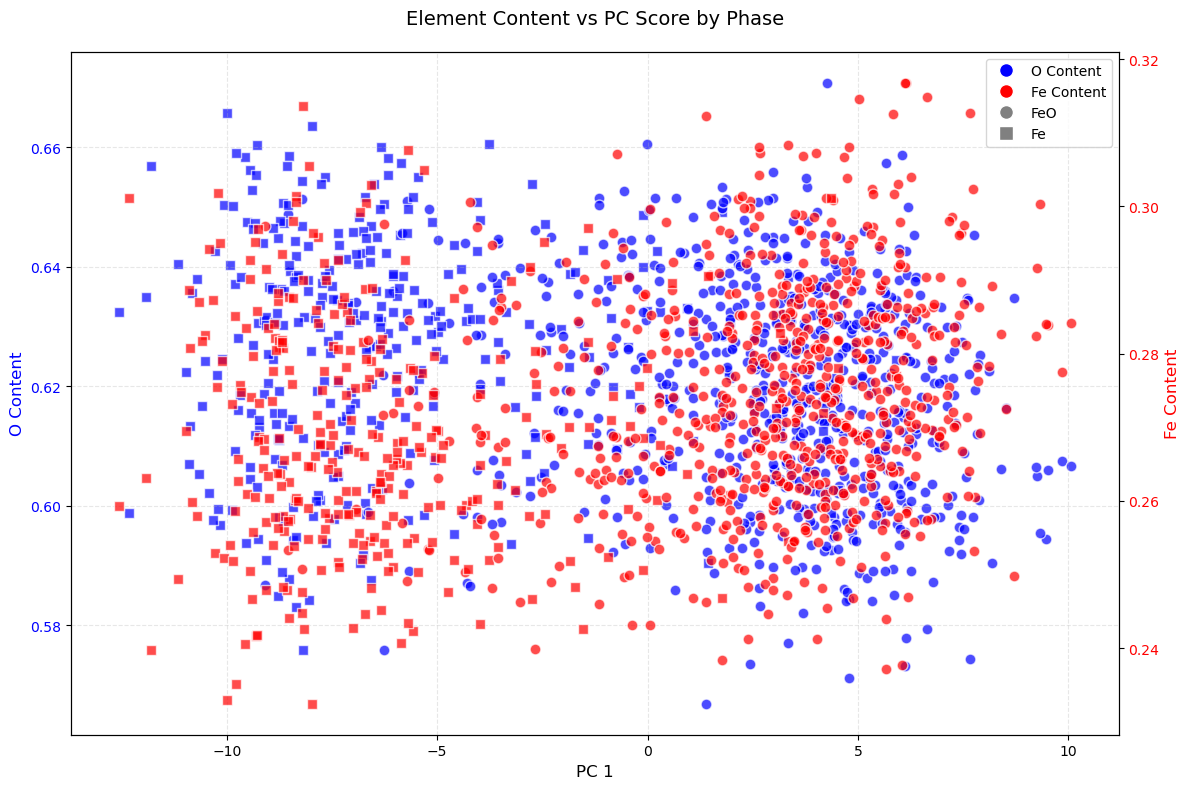

In [11]:
loc_p = np.array(loc_p)
phase_map = {
    2: 'FeO',
    3: 'Fe'
}
plot_element_vs_pca(pca_scores1[:,0],roi_eds, loc_p, coor_dict, phase_map,(15,10))